## CS 4501 Computer Vision
[Project 2: Stereo matching and homographies](http://www.cs.virginia.edu/~connelly/class/2017/intro_vision/proj2/)

By Charlie Wu, jw7jb

In [1]:
import cv2, skimage, skimage.io, random, skimage.transform, numpy.linalg
import scipy.ndimage as ndi
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

**Simple stereo matching**
- Load the left and right camera images (we suggest to use the above image pair), and convert these to float arrays.
- Establish a maximum disparity value based on the size of the image. For this input pair, a maximum disparity of about 1/3 the height of the image works well.

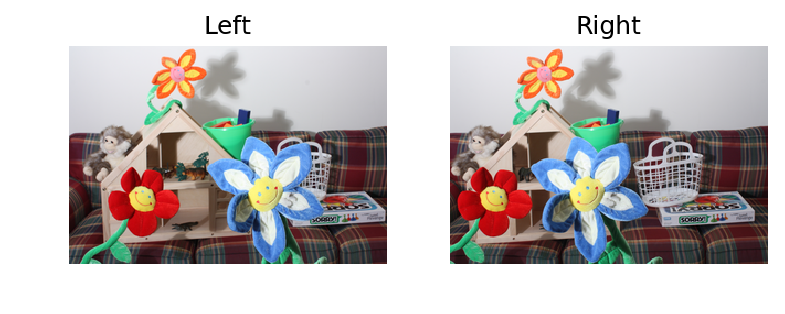

In [2]:
raw_l = skimage.img_as_float(skimage.io.imread('left.png'))
raw_r = skimage.img_as_float(skimage.io.imread('right.png'))

fig = plt.figure(dpi = 150)
a=fig.add_subplot(121)
a.axis('off')
plt.imshow(raw_l)
a.set_title('Left')
a=fig.add_subplot(122)
a.axis('off')
plt.imshow(raw_r)
a.set_title('Right')

x = raw_l.shape[0]
y = raw_l.shape[1]

d = x//3


- Find the ***disparity space image*** (DSI), which is a 3D array with coordinates (x, y, d). This can be established by taking the difference between the color of the pixel (x, y) in the left image and a pixel that has been appropriately horizontally shifted to the left by d in the right image. 

In [3]:
DSI_1 = np.zeros([d,x,y])
for k in range(d):
    for i in range(x):
        for j in range(y):
            DSI_1[k][i][j] = np.sum((raw_l[i][j][0:3]-raw_r[i][j-k][0:3])**2)

DSI_2 = np.zeros([d,x,y])
for k in range(d):
    for i in range(x):
        for j in range(y):
            if j+k < y:
                DSI_2[k][i][j] = np.sum((raw_l[i][j+k][0:3]-raw_r[i][j][0:3])**2)
            else:
                DSI_2[k][i][j] = np.sum((raw_l[i][y-1][0:3]-raw_r[i][j][0:3])**2)

- For each disparity d, perform ***spatial aggregation*** on the DSI by using a ***Gaussian filter*** across all spatial coordinates (x, y).
- For each pixel (x, y), choose out the depth d that gives the smallest DSI value after the aggregation step.
- One issue with the previous algorithm is that it does not ***preserve sharp edges** when aggregating spatially with the Gaussian filter. Use the ***bilateral filter***, which is a filter that blurs out an image while preserving strong edges. 

In [4]:
def gaussian_depth(DSI, sg):
    dmap = np.zeros([x,y])
    DSI_gaussian = np.zeros([d,x,y])
    for k in range(0,d):
        DSI_gaussian[k] = skimage.filters.gaussian(DSI[k], sigma=sg)

    for i in range(x):
        for j in range(y):
            min_d = -1
            min_dsi = 9999
            for k in range(d):
                dist_sum = DSI_gaussian[k][i][j]
                if min_dsi > dist_sum:
                    min_dsi = dist_sum
                    min_d = k
            dmap[i][j] = min_d
    return dmap

def bilateral_depth(DSI, joint):
    nmap = np.zeros([x,y])
    DSI_Bilateral = np.zeros([d,x,y]) 
    for k in range(0,d):
        DSI_Bilateral[k] = cv2.ximgproc.jointBilateralFilter(joint.astype(np.float32), DSI[k].astype(np.float32), 10, 3, 3)

    for i in range(x):
        for j in range(y):
            min_d = -1
            min_dsi = 9999
            for k in range(d):
                dist_sum = DSI_Bilateral[k][i][j]
                if min_dsi > dist_sum:
                    min_dsi = dist_sum
                    min_d = k
            nmap[i][j] = min_d
    return nmap

dmap_1 = gaussian_depth(DSI_1, .75)
nmap_1 = bilateral_depth(DSI_1, raw_l)
dmap_2 = gaussian_depth(DSI_2, .75)
nmap_2 = bilateral_depth(DSI_2, raw_r)

- Visualize your depth map and compare it with the ground truth depth map for your image pair, Print out the [root-mean-square](https://en.wikipedia.org/wiki/Root_mean_square) (RMS) distance between the ground truth depth and your depth. 

RMS distance with gaussian: 12.7824466742
RMS distance with bilateral: 13.1280188273
left over right


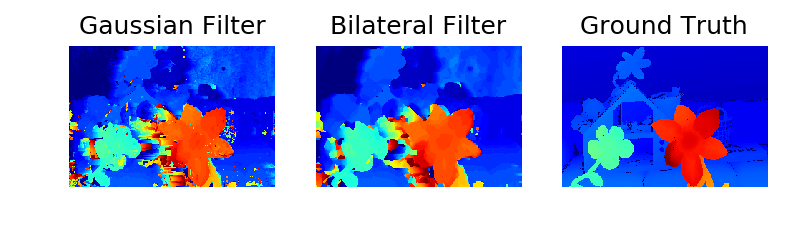

In [5]:
ground_truth = np.load("gt.npy")
fig = plt.figure(dpi = 150)
f=fig.add_subplot(131)
f.axis('off')
plt.imshow(dmap_1, cmap=plt.cm.jet)
f.set_title('Gaussian Filter')
f=fig.add_subplot(132)
f.axis('off')
plt.imshow(nmap_1, cmap=plt.cm.jet)
f.set_title('Bilateral Filter')
f=fig.add_subplot(133)
f.axis('off')
plt.imshow(ground_truth, cmap=plt.cm.jet)
f.set_title('Ground Truth')

dis_d = np.sqrt(np.sum((ground_truth-dmap_1)**2)/(x*y))
dis_n = np.sqrt(np.sum((ground_truth-nmap_1)**2)/(x*y))

print("RMS distance with gaussian:",dis_d)
print("RMS distance with bilateral:",dis_n)
print("left over right")

- A second issue with the previous algorithm is that it does handle occluded or mismatched regions well. Implement what is called a ***left-right consistency check***. The occulsion threshold is set as 15

RMS distance occlution detection: 9.6487828026


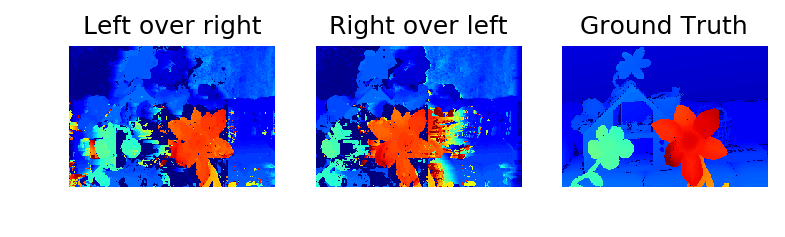

In [6]:
occlution = np.zeros([x,y-2*d])
count = 0
for i in range(x):
    for j in range(y-2*d):
        if abs(dmap_1[i][j+d]-dmap_2[i][j])>15:
            count += 1
            occlution[i][j] = -1
            dmap_1[i][j+d] = -1
            dmap_2[i][j] = -1
            
ground_truth = np.load("gt.npy")
fig = plt.figure(dpi = 150)
f=fig.add_subplot(131)
f.axis('off')
plt.imshow(dmap_1, cmap=plt.cm.jet)
f.set_title('Left over right')
f=fig.add_subplot(132)
f.axis('off')
plt.imshow(dmap_2, cmap=plt.cm.jet)
f.set_title('Right over left')
f=fig.add_subplot(133)
f.axis('off')
plt.imshow(ground_truth, cmap=plt.cm.jet)
f.set_title('Ground Truth')

dist = 0
for i in range(x):
    for j in range(y):
        if dmap_1[i][j] != -1:
            dist += (ground_truth[i][j]-dmap_1[i][j])**2
dist =  np.sqrt(dist/(x*y-count))
print("RMS distance occlution detection:",dist)

**Panorama stitching using homographies **
- Load images A and B using cv2.imread()
- Compute keypoints and SIFT descriptors for images A and B
- Write a function that applies a homography matrix H to a point (xb, yb) in image B, returning a point (xa, ya) in image A.
- Write a function that fits a homography

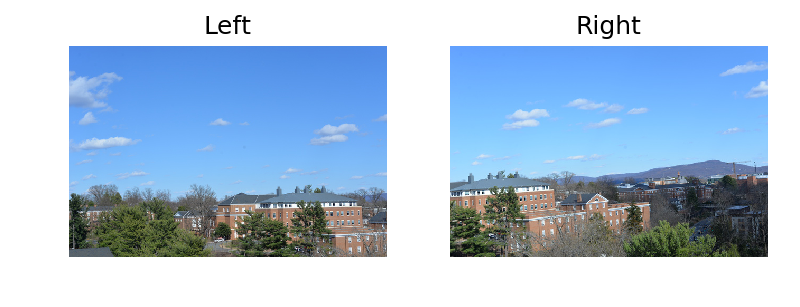

In [7]:
a=cv2.imread("a.jpg")
b=cv2.imread("b.jpg")

fig = plt.figure(dpi = 150)
ax=fig.add_subplot(121)
ax.axis('off')
plt.imshow(skimage.img_as_float(a)[:,:,::-1])
ax.set_title('Left')
ax=fig.add_subplot(122)
ax.axis('off')
plt.imshow(skimage.img_as_float(b)[:,:,::-1])
ax.set_title('Right')

sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(a,None)
kp2, des2 = sift.detectAndCompute(b,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

def proj(h, x, y):
    div = h[2][0]*x+h[2][1]*y+h[2][2]
    xa = (h[0][0]*x+h[0][1]*y+h[0][2])/div
    ya = (h[1][0]*x+h[1][1]*y+h[1][2])/div
    return xa, ya

def solve(sample):
    A = np.ones([4,3])
    B = np.ones([4,3])
    # exp2=[[0, 0], [1, 0], [0, 1], [1, 1]]
    # exp1=[[1, 2], [3, 2], [1, 4], [3, 4]]
    #     A[i][0] = exp1[i][0]
    #     A[i][1] = exp1[i][1]
    #     B[i][0] = exp2[i][0]
    #     B[i][1] = exp2[i][1]
    for i in range(4):
        B[i][0] = kp1[sample[i].queryIdx].pt[0]
        B[i][1] = kp1[sample[i].queryIdx].pt[1]
#         print(sample[i].queryIdx)
        A[i][0] = kp2[sample[i].trainIdx].pt[0]
        A[i][1] = kp2[sample[i].trainIdx].pt[1]
    return np.linalg.lstsq(A,B)
#a d g
#b e h
#c f i

- Write a function that uses RANSAC to compute the best homography mapping image B coordinates to image A coordinates. 
    - Use random.sample to randomly sample four pairs of matched features
    - Fit a homography H that maps from image B points to image A points, using the function ***proj***
    - Count inliers based on $  \left\Vert Hbi - ai  \right\Vert < \epsilon $
- RANSAC should then return the homography H corresponding to the largest set of inliers.

In [8]:
mn = 1e10
H = np.zeros([3,3])
for epoch in range(1000):
    sp = random.sample(good, 4)
#     print(sp)
    res = solve(sp)
    if mn > np.sum(res[1]): 
        mn = np.sum(res[1])
        H = res[0]
H=H.T
print("Best homography:")
print(H)
print("With loss of", mn)

Best homography:
[[  9.60288429e-01  -4.36385972e-03   3.60037332e+02]
 [  5.77568716e-02   9.73055947e-01   2.93062804e+01]
 [ -5.05111955e-18   5.07125548e-18   1.00000000e+00]]
With loss of 2.50688287252e-30


- Warp image B to image A's coordinate system by applying the homography H, and composite the two images.
- The above printed-out matrix is the best homography matrix found by RANSAC and the composite panorama image is shown below
- **Bonus:** The final composite image does not look that great because it has a seam in it. Determine the distances to the region where only a pixels exist, and the region where only b pixels exist using a distance transform, and use these distances to make a smooth interpolation.

/Users/wujibang/Developer/Python/anaconda3/envs/cv-project2/lib/python3.4/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


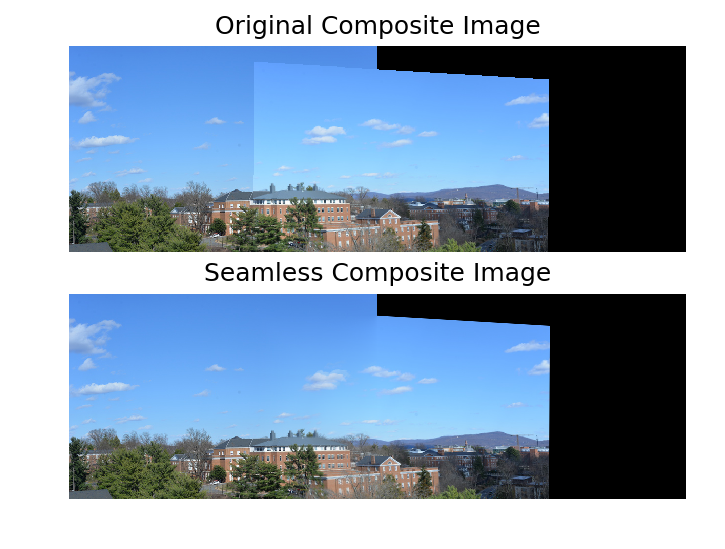

In [9]:
def composite_warped(a, b, H):
    "Warp images a and b to a's coordinate system using the homography H which maps b coordinates to a coordinates."
    out_shape = (a.shape[0], 2*a.shape[1])                               # Output image (height, width)
    p = skimage.transform.ProjectiveTransform(numpy.linalg.inv(H))       # Inverse of homography (used for inverse warping)
    bwarp = skimage.transform.warp(b, p, output_shape=out_shape)         # Inverse warp b to a coords
    bvalid = numpy.zeros(b.shape, 'uint8')                               # Establish a region of interior pixels in b
    bvalid[1:-1,1:-1,:] = 255
    bmask = skimage.transform.warp(bvalid, p, output_shape=out_shape)    # Inverse warp interior pixel region to a coords
    apad = numpy.hstack((skimage.img_as_float(a), numpy.zeros(a.shape))) # Pad a with black pixels on the right
    bmask1 = np.copy(bmask)
    for i in range (a.shape[0]):
        for j in range(a.shape[1],out_shape[1]):
            bmask1[i][j] = 1
    bmask2 = np.copy(bmask)  
    for i in range (a.shape[0]):
        for j in range(0,a.shape[1]):
            bmask2[i][j] = 1
        for j in range(a.shape[1],out_shape[1]):
            if bwarp[i][j].all() == 0:
                bmask2[i][j] = 1
            else: bmask2[i][j] = 0
    blend1 = ndi.distance_transform_edt(bmask1)
    blend2 = ndi.distance_transform_edt(bmask2)

    result = np.copy(apad)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if bmask[i][j].any() == 1.0:
                result[i][j] = blend1[i][j]/(blend1[i][j]+blend2[i][j])*bwarp[i][j] \
                + blend2[i][j]/(blend1[i][j]+blend2[i][j])*apad[i][j]
        for j in range(a.shape[1],out_shape[1]):
            result[i][j] = bwarp[i][j]
    return (skimage.img_as_ubyte(numpy.where(bmask==1.0, bwarp, apad)), result)    # Select either bwarp or apad based on mask

original, seamless  = composite_warped(a,b,H)
fig = plt.figure(dpi = 150)
f=fig.add_subplot(211)
f.axis('off')
plt.imshow(original[:,:,::-1])
f.set_title('Original Composite Image')
f=fig.add_subplot(212)
f.axis('off')
plt.imshow(seamless[:,:,::-1])
f.set_title('Seamless Composite Image')
